In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

import seaborn as sns

from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize 
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.cof import COF

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,auc

In [2]:
def import_csv(csv_file):
    
    columns=(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','TV'])
    df=pd.read_csv(csv_file, names=columns)
    df['TV'].replace(to_replace=['o','n'],value=[1,0] , inplace=True) #for hbos,knn,cof
    #df['TV'].replace(to_replace=['o','n'],value=[1,-1] , inplace=True) #for lof
    
    return df


In [3]:
def normalize():
    df=import_csv('thyroid.csv')
    
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    scaler.fit(df.drop("TV",axis=1))
    scaled_features=scaler.transform(df.drop("TV",axis=1))
    df_feat=pd.DataFrame(scaled_features,columns=df.columns[:-1])
    return df_feat

In [4]:
def classify_knn():
    print("CSV file is being imported..")
    print("String to binary conversion...")
    df=import_csv('thyroid.csv')
    print("Data Standardization in process...\n: which gives data zero mean and unit variance")
    df_feat=normalize()
    print("Train test split in process...")
    X=df_feat
    y=df["TV"]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
    from sklearn.neighbors import KNeighborsClassifier
    k = 4
    #Train Model 
    print("Training the model...")
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    neigh
    #Predicting
    print("Prediciting the model...")
    yhat = neigh.predict(X_test)
    yhat[0:5]
    print("Accuracy evaluation in process...")
    from sklearn import metrics
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
    print("Accuracy of KNN for different Ks")
    Ks = 50
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    ConfustionMx = [];
    for n in range(1,Ks):
        print("Checking k="+str(n))
        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        yhat=neigh.predict(X_test)
        mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)


        std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    print("Calculating mean accuracy...")
    print(mean_acc)
    plt.plot(range(1,Ks),mean_acc,'g')
    plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Nabors (K)')
    plt.tight_layout()
    plt.show()
    print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
    print("calculating confusion matrix...")
    print(confusion_matrix(y_test,yhat))
    print("Giving Classification report...")
    print(classification_report(y_test,yhat))
    print("Plotting error rate plot...")
    print("Calculating error for K values between 1 and 40")
    error = []

    for i in range(1, 40):
        print("Checking k="+str(i))
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test))

    print("Plotting error rate plot...")
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')
    plt.show()
    print("plotting roc auc curve...")
    y_scores=knn.predict_proba(X_test)
    y_test=np.asarray(y_test)
    y_test_true=np.asarray(y_test)
    fpr,tpr,threshold=metrics.roc_curve(y_test,y_scores[:,-1])
    roc_auc = metrics.auc(fpr,tpr)
    roc_auc = auc(fpr, tpr)
    plt.title ("ROC curve for knn=4")
    plt.plot(fpr,tpr,"b",label="AUC=%0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0,1],[0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.show()

In [5]:
def classify_hbos():
    print("CSV file is being imported..")
    print("str to binary conversion...")
    df=import_csv('thyroid.csv')
    print("Data Standardization in process... \n : which gives data zero mean and unit variance")
    df_feat=normalize()
    print("Train test split in process...")
    X=df_feat
    y=df["TV"]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
    print("implementing HBOS algorithm")
    hbos = HBOS(n_bins= 20)
    hbos.fit(X_train)
    HBOS(alpha = 0.1,contamination = 0.1,n_bins = 20,tol = 0.5)
    Y_train_pred1 = hbos.labels_
    Y_train_scores = hbos.decision_scores_

    Y_test_pred1 = hbos.predict(X_test)
    Y_test_scores1 = hbos.decision_function(X_test)
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, Y_train_pred1))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, Y_test_pred1))
    print("Plotting roc auc curve")
    fpr1, tpr1, threshold1 = metrics.roc_curve(y_test,Y_test_scores1)
    roc_auc1 = metrics.auc(fpr1,tpr1)
    roc_auc1
    plt.plot(fpr1, tpr1,"b",label="AUC=%0.2f" % roc_auc1)
    plt.legend(loc="lower right")
    plt.plot([0,1],[0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
    
    

    
    print("calculating confusion matrix...")
    cm1 = confusion_matrix(y_test, Y_test_pred1)
    print("cm1")
    print("Giving Classification report...")
    print(classification_report(y_test,Y_test_pred1))
    print("Plotting error rate plot...")
    error_rate1 = []
    for i in range(10,50): 
        print("Checking n_bins ="+str(i))
        hbos = HBOS(n_bins= i)
        hbos.fit(X_train)
        HBOS(alpha = 0.1,contamination = 0.1,n_bins = i,tol = 0.5)
        pred_i1 = hbos.predict(X_test)
        error_rate1.append(np.mean(pred_i1 != y_test))
    


    plt.figure(figsize=(15,10))
    plt.title('error rate vs N_bins')
    plt.xlabel('N_bins')
    plt.ylabel('Mean.error')
    plt.plot(range(10,50),error_rate1,color='red',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=10)  
    

In [6]:
def classify_lof():
    print("WITHOUT NOVELTY")
    print("novelty=False")
    print("CSV file is being imported..")
    print("str to binary conversion...")
    df=import_csv('thyroid.csv')
    print("Data Standardization in process... \n : which gives data zero mean and unit variance")
    df_feat=normalize()
    print("Train test split in process...")
    #X = df.iloc[:,0:31] #independent variables
    #y = np.array(df['TV']) #dependent variables 
    x=df_feat
    y=df["TV"]
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 0)
    lof = LocalOutlierFactor(n_neighbors=20, novelty=False, contamination=0.1)
    lof.fit_predict(xtrain)
    lof.fit_predict(xtest)
    y_hat = lof.fit_predict(x)
    n_errors = (y_hat != y)
    print(n_errors)
    error_percent = n_errors/len(y)
    print(error_percent)
    error_rate = []
    accuracy = []
    for i in range(1,51):
        print("n_neighbors ="+str(i))
        lof = LocalOutlierFactor(n_neighbors = i, novelty = False, contamination = 10/len(y))
        y_hat_i = lof.fit_predict(x)
        n_error_i = (y_hat_i != y).sum()
        error_rate.append(n_error_i/len(y)*100)
        accuracy.append((len(y) - n_error_i)/len(y)*100)
    plt.figure(figsize=(15,10))
    plt.title('error rate vs K value')
    plt.xlabel('K value')
    plt.ylabel('Mean.error')
    plt.plot(range(1,51), error_rate ,color='red',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=10) 
    plt.figure(figsize=(15,10))
    plt.title('Accuracy vs K value')
    plt.xlabel('K value')
    plt.ylabel('Accuracy')
    plt.plot(range(1,51), accuracy ,color='red',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=10) 
    sns.lineplot(range(1,51), accuracy)
    metrics.roc_curve(y, y_hat)
    fpr, tpr, threshold = metrics.roc_curve(y, y_hat)
    plt.plot(fpr, tpr)
    
    print("WITH NOVELTY")
    print("novelty=True")
    print("CSV file is being imported..")
    print("str to binary conversion...")
    df=import_csv('Requests_reduced.csv')
    print("Data Standardization in process... \n : which gives data zero mean and unit variance")
    df_feat=normalize()
    print("Train test split in process...")
    X = df.iloc[:,0:31]
    Y=(df["TV"]==0)
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    plt.figure(figsize = (15,5))
    error_percent = []
    accuracy_percent = []
    for i in range(1,100):
        print("n_neighbors ="+str(i))
        clf = LocalOutlierFactor(n_neighbors = i, novelty = True, contamination = 0.1) # contamination = 0 as no outliers in this case
        clf.fit(X)
        y_hat = clf.predict(X)
        n_errors = np.count_nonzero(y_hat != Y)
        error_percent.append(n_errors/len(Y)*100)
        accuracy_percent.append((len(Y)-n_errors)/len(Y)*100)
    sns.lineplot(range(1,100), accuracy_percent)
    sns.lineplot(range(1,100), error_percent)
    metrics.roc_curve(Y, y_hat)
    fpr, tpr, threshold = metrics.roc_curve(Y, y_hat)
    plt.plot(fpr, tpr)


In [7]:
def classify_cof():
    print("Classifying COF...")
    print("CSV file is being imported...")
    print("str to binary conversion...")
    df=import_csv('thyroid.csv')
    print("Data Standardization in process... \n : which gives data zero mean and unit variance")
    df_feat=normalize()
    print("Train test split in process...")
    #X = df.iloc[:,0:31] #independent variables
    #y = np.array(df['TV']) #dependent variables 
    x=df_feat
    y=df["TV"]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 4)
    cof = COF(n_neighbors=20)
    cof.fit(X_train)
    COF(contamination=0.1, n_neighbors=20)
    Y_train_pred1 = cof.labels_
    Y_train_scores = cof.decision_scores_

    Y_test_pred1 = cof.predict(X_test)
    Y_test_scores1 = cof.decision_function(X_test)
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, Y_train_pred1))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, Y_test_pred1))
    
    
    print("Printing roauc")
    fpr1, tpr1, threshold1 = metrics.roc_curve(y_test,Y_test_scores1)
    roc_auc1 = metrics.auc(fpr1,tpr1)
    roc_auc1
    plt.plot(fpr1, tpr1)
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show
    print("Printing classification report")
    print(classification_report(y_test,Y_test_pred1))
    print("getting error rate curve")
    error_rate1 = []
    for i in range(10,50): 
        print("n_neighbors ="+str(i))
        cof = COF(n_neighbors= i)
        cof.fit(X_train)
        COF(contamination = 0.1,n_neighbors = i)
        pred_i1 = cof.predict(X_test)
        error_rate1.append(np.mean(pred_i1 != y_test))


    
    plt.figure(figsize=(15,10))
    plt.title('error rate vs N_bins')
    plt.xlabel('N_bins')
    plt.ylabel('Mean.error')
    plt.plot(range(10,50),error_rate1,color='red',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=10) 
    
    

In [8]:
#calling
#classify_knn()
#classify_hbos()
#classify_lof_without_novelty()
#classify_lof_with_novelty()
#classify_cof

CSV file is being imported..
String to binary conversion...
Data Standardization in process...
: which gives data zero mean and unit variance
Train test split in process...
Training the model...
Prediciting the model...
Accuracy evaluation in process...
Train set Accuracy:  0.9760380086758934
Test set Accuracy:  0.9744578313253012
Accuracy of KNN for different Ks
Checking k=1
Checking k=2
Checking k=3
Checking k=4
Checking k=5
Checking k=6
Checking k=7
Checking k=8
Checking k=9
Checking k=10
Checking k=11
Checking k=12
Checking k=13
Checking k=14
Checking k=15
Checking k=16
Checking k=17
Checking k=18
Checking k=19
Checking k=20
Checking k=21
Checking k=22
Checking k=23
Checking k=24
Checking k=25
Checking k=26
Checking k=27
Checking k=28
Checking k=29
Checking k=30
Checking k=31
Checking k=32
Checking k=33
Checking k=34
Checking k=35
Checking k=36
Checking k=37
Checking k=38
Checking k=39
Checking k=40
Checking k=41
Checking k=42
Checking k=43
Checking k=44
Checking k=45
Checking k=46

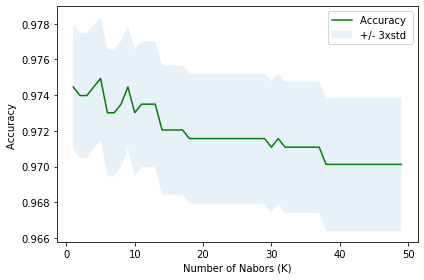

The best accuracy was with 0.9749397590361446 with k= 5
calculating confusion matrix...
[[2002    0]
 [  62   11]]
Giving Classification report...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2002
           1       1.00      0.15      0.26        73

    accuracy                           0.97      2075
   macro avg       0.98      0.58      0.62      2075
weighted avg       0.97      0.97      0.96      2075

Plotting error rate plot...
Calculating error for K values between 1 and 40
Checking k=1
Checking k=2
Checking k=3
Checking k=4
Checking k=5
Checking k=6
Checking k=7
Checking k=8
Checking k=9
Checking k=10
Checking k=11
Checking k=12
Checking k=13
Checking k=14
Checking k=15
Checking k=16
Checking k=17
Checking k=18
Checking k=19
Checking k=20
Checking k=21
Checking k=22
Checking k=23
Checking k=24
Checking k=25
Checking k=26
Checking k=27
Checking k=28
Checking k=29
Checking k=30
Checking k=31
Checking k=32
Checking k=

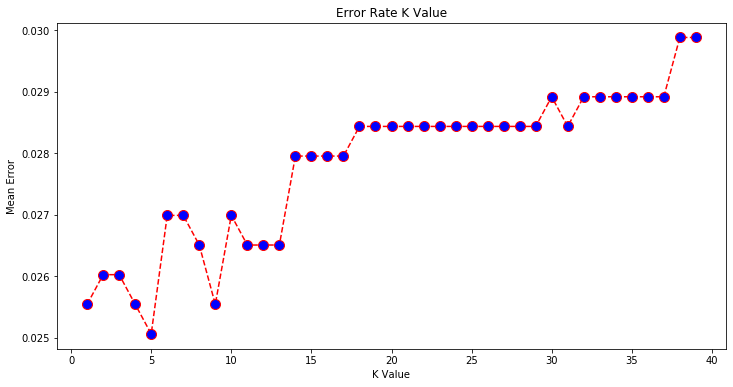

plotting roc auc curve...


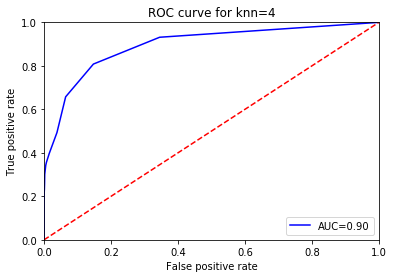

In [9]:
classify_knn()

CSV file is being imported..
str to binary conversion...
Data Standardization in process... 
 : which gives data zero mean and unit variance
Train test split in process...
implementing HBOS algorithm
Train set Accuracy:  0.8824623011774427
Test set Accuracy:  0.8780722891566265
Plotting roc auc curve


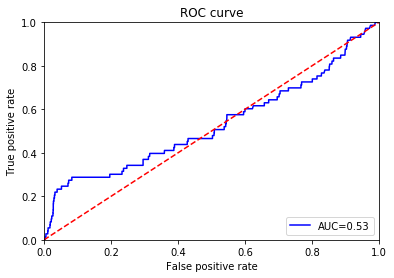

calculating confusion matrix...
cm1
Giving Classification report...
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2002
           1       0.09      0.29      0.14        73

    accuracy                           0.88      2075
   macro avg       0.53      0.59      0.54      2075
weighted avg       0.94      0.88      0.91      2075

Plotting error rate plot...
Checking n_bins =10
Checking n_bins =11
Checking n_bins =12
Checking n_bins =13
Checking n_bins =14
Checking n_bins =15
Checking n_bins =16
Checking n_bins =17
Checking n_bins =18
Checking n_bins =19
Checking n_bins =20
Checking n_bins =21
Checking n_bins =22
Checking n_bins =23
Checking n_bins =24
Checking n_bins =25
Checking n_bins =26
Checking n_bins =27
Checking n_bins =28
Checking n_bins =29
Checking n_bins =30
Checking n_bins =31
Checking n_bins =32
Checking n_bins =33
Checking n_bins =34
Checking n_bins =35
Checking n_bins =36
Checking n_bins =37
Checking n_bins =

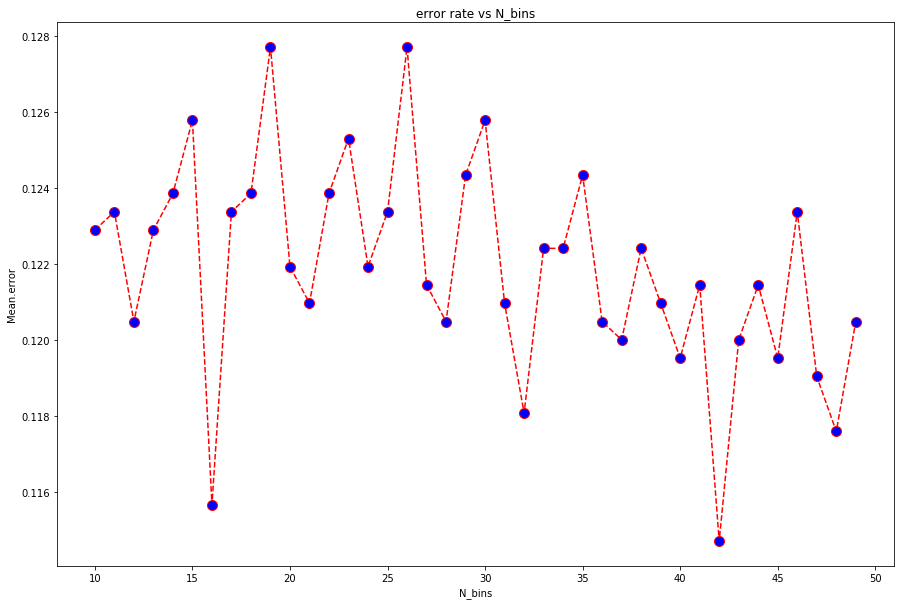

In [10]:
classify_hbos()

WITHOUT NOVELTY
novelty=False
CSV file is being imported..
str to binary conversion...
Data Standardization in process... 
 : which gives data zero mean and unit variance
Train test split in process...
0        True
1        True
2        True
3       False
4        True
        ...  
6911     True
6912     True
6913     True
6914     True
6915     True
Name: TV, Length: 6916, dtype: bool
0       0.000145
1       0.000145
2       0.000145
3       0.000000
4       0.000145
          ...   
6911    0.000145
6912    0.000145
6913    0.000145
6914    0.000145
6915    0.000145
Name: TV, Length: 6916, dtype: float64
n_neighbors =1
n_neighbors =2
n_neighbors =3
n_neighbors =4
n_neighbors =5
n_neighbors =6
n_neighbors =7
n_neighbors =8
n_neighbors =9
n_neighbors =10
n_neighbors =11
n_neighbors =12
n_neighbors =13
n_neighbors =14
n_neighbors =15
n_neighbors =16
n_neighbors =17
n_neighbors =18
n_neighbors =19
n_neighbors =20
n_neighbors =21
n_neighbors =22
n_neighbors =23
n_neighbors =24
n_neigh

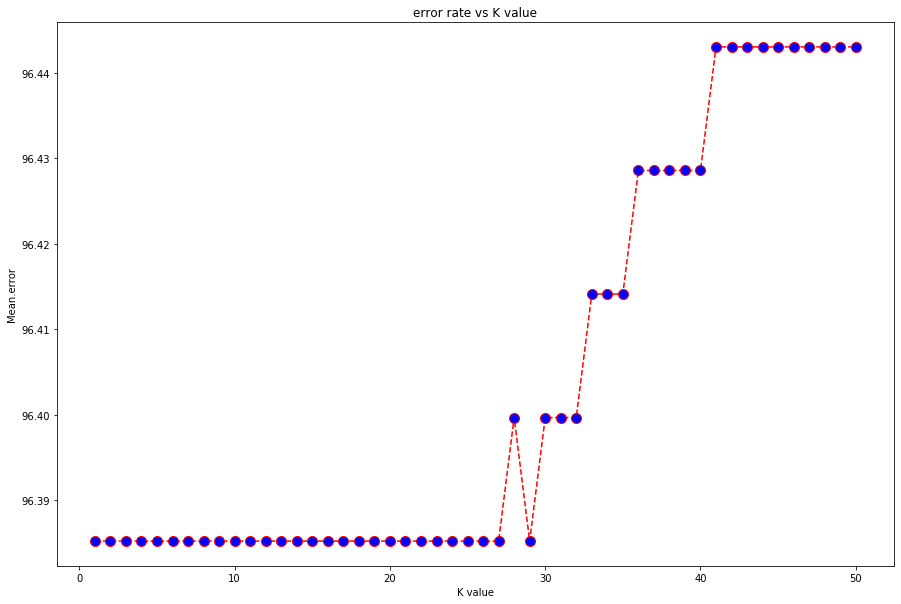

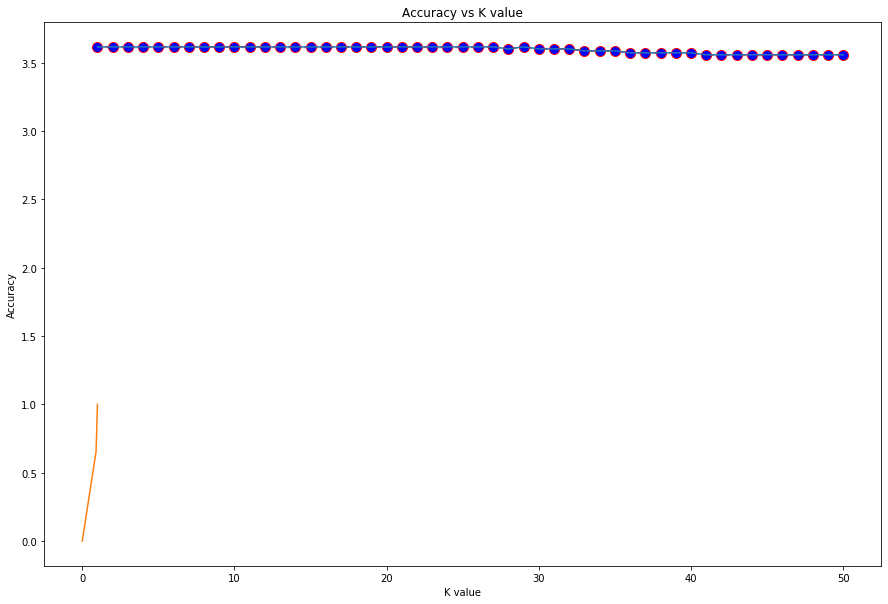

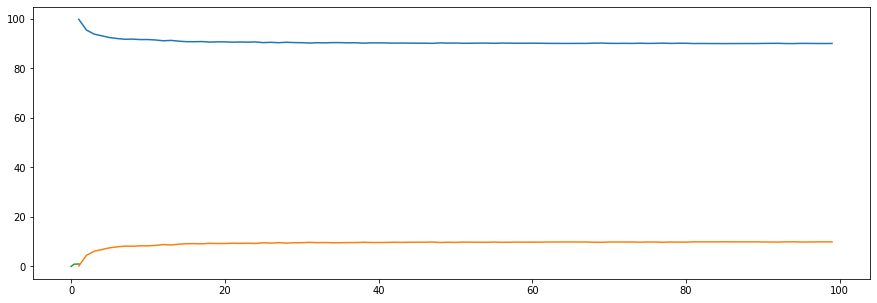

In [11]:
classify_lof()

Classifying COF...
CSV file is being imported...
str to binary conversion...
Data Standardization in process... 
 : which gives data zero mean and unit variance
Train test split in process...
Train set Accuracy:  0.8861805412104937
Test set Accuracy:  0.88
Printing roauc
Printing classification report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2002
           1       0.13      0.42      0.20        73

    accuracy                           0.88      2075
   macro avg       0.55      0.66      0.57      2075
weighted avg       0.95      0.88      0.91      2075

getting error rate curve
n_neighbors =10
n_neighbors =11
n_neighbors =12
n_neighbors =13
n_neighbors =14
n_neighbors =15
n_neighbors =16
n_neighbors =17
n_neighbors =18
n_neighbors =19
n_neighbors =20
n_neighbors =21
n_neighbors =22
n_neighbors =23
n_neighbors =24
n_neighbors =25
n_neighbors =26
n_neighbors =27
n_neighbors =28
n_neighbors =29
n_neighbors =30
n_neighbo

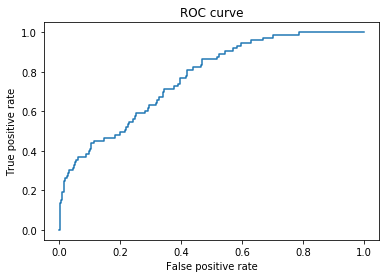

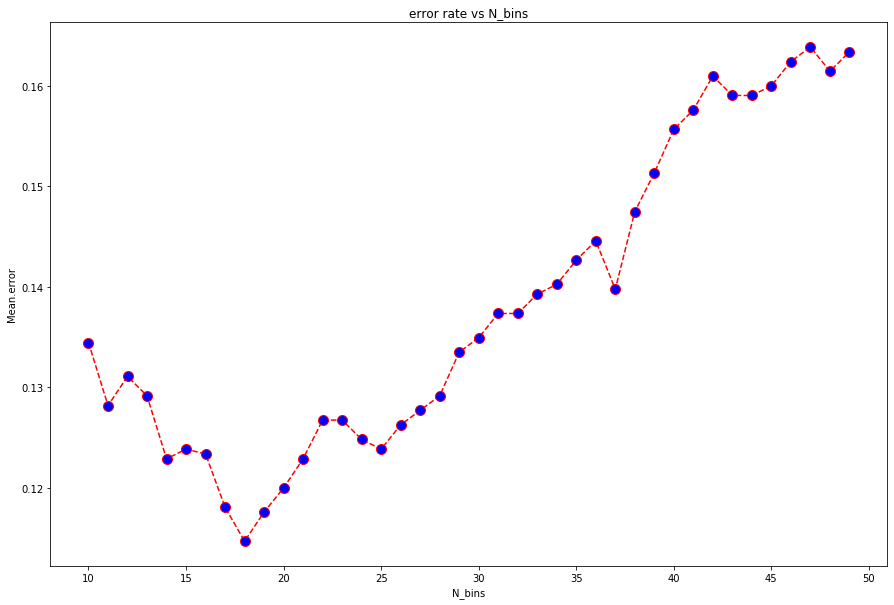

In [13]:
classify_cof()